***

<font color='green'>

# Project Solution: Recommender Systems
### Filename: Electronic_dataset.csv (http://jmcauley.ucsd.edu/data/amazon/)
### File consists of data for user_id, prod_id, ratings, timestamp
### Purpose: Make a recommendation system that recommends at least five new products based on the user's habits
### Learning Outcome: EDA, Data Wrangling, Build Popularity Recommender Model, Build Collaborative Filtering Model
***
***
*Prepared by: Sauvik De*

*Date: December 14, 2020*
    
</font>

***

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, KNNWithMeans, SVD, accuracy
from surprise.model_selection import train_test_split
from IPython.display import display_html, display, HTML

In [2]:
# Define utility function

def get_top_k(predictions, k=10):
    '''Return the top-K recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        k(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size k.
    '''

    from collections import defaultdict
    
    # First map the predictions to each user.
    top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = user_ratings[:k]

    return top_k

In [3]:
# Load user-product rating data
# Note: The datafile 'Electronic_dataset.csv' is stored under the same folder as that of this ipynb notebook

rating = pd.read_csv('Electronic_dataset.csv', sep=',', header=0)

### Exploratory Data Analysis

In [4]:
print(f'The shape of the dataframe is {rating.shape}')
print('\nFirst few rows of the dataframe:')
rating.head()

The shape of the dataframe is (500000, 4)

First few rows of the dataframe:


,user_id,prod_id,ratings,timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


In [5]:
# Check columns and their datatypes

print("\n1) Dataset doesn't seem to have missing values with user ID and product ID being character type, while product ratings \
and timestamp being numerical.\n2) Product rating is on a scale of 1-5.\n3) There are 448368 unique users and 130138 unique products.")
print('\n')
print(rating.info())
print(rating.describe(include='all'))


1) Dataset doesn't seem to have missing values with user ID and product ID being character type, while product ratings and timestamp being numerical.
2) Product rating is on a scale of 1-5.
3) There are 448368 unique users and 130138 unique products.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
user_id      500000 non-null object
prod_id      500000 non-null object
ratings      500000 non-null float64
timestamp    500000 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ MB
None
              user_id     prod_id        ratings     timestamp
count          500000      500000  500000.000000  5.000000e+05
unique         448368      130138            NaN           NaN
top     A680RUE1FDO8B  B0074BW614            NaN           NaN
freq               36        1138            NaN           NaN
mean              NaN         NaN       4.013172  1.338261e+09
std               NaN         NaN       1.3799


Most of the ratings (~56%) provided by users is 5 (highest rating).


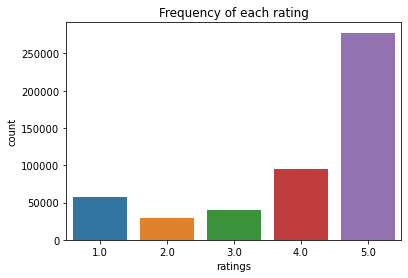

In [6]:
# Analysis of ratings frequency

_ = sns.countplot(x='ratings', data=rating).set_title('Frequency of each rating')

RatingProp = rating['ratings'].value_counts() / rating.shape[0]
maxRating = '{:.0%}'.format(RatingProp.max())
print('\n'f'Most of the ratings (~{maxRating}) provided by users is 5 (highest rating).')

In [7]:
# drop "timestamp" column as this is not required for analysis

rating.drop(columns='timestamp', axis=1, inplace=True)

In [8]:
# Let's do some ratings analysis at product level

ratingStatbyProd = rating.groupby(['prod_id']).agg({'user_id':'count','ratings':'mean'})
ratingStatbyProd.reset_index(inplace=True)
ratingStatbyProd.rename(columns = {'user_id': 'RatingCount','ratings':'RatingAvg'}, inplace=True)
print("\nRating details by Product ID ordered by rating count:\n", ratingStatbyProd.sort_values(by=['RatingCount', 'RatingAvg'], ascending=False))
print("\nRating details by Product ID ordered by mean rating:\n", ratingStatbyProd.sort_values(by=['RatingAvg', 'RatingCount'], ascending=False))


Rating details by Product ID ordered by rating count:
            prod_id  RatingCount  RatingAvg
90638   B0074BW614         1138   4.465729
120766  B00DR0PDNE         1094   3.943327
95656   B007WTAJTO          883   4.417894
31800   B0019EHU8G          774   4.740310
87388   B006GWO5WK          770   4.275325
...            ...          ...        ...
130095  B00KSU1XNU            1   1.000000
130098  B00KVGAN3W            1   1.000000
130112  B00L0RQ0T2            1   1.000000
130113  B00L15FOF4            1   1.000000
130125  B00L6GWAFU            1   1.000000

[130138 rows x 3 columns]

Rating details by Product ID ordered by mean rating:
            prod_id  RatingCount  RatingAvg
116624  B00C9TECFO           19        5.0
49031   B002XN3OL4           17        5.0
30313   B0015VW3BM           16        5.0
40941   B00212NO6W           16        5.0
63706   B0045JCFLY           16        5.0
...            ...          ...        ...
130095  B00KSU1XNU            1        1.0
13

- From the above result, there are as many as 1138 ratings provided by a single user for a product, while there seems to be multiple cases with only 1 product rating

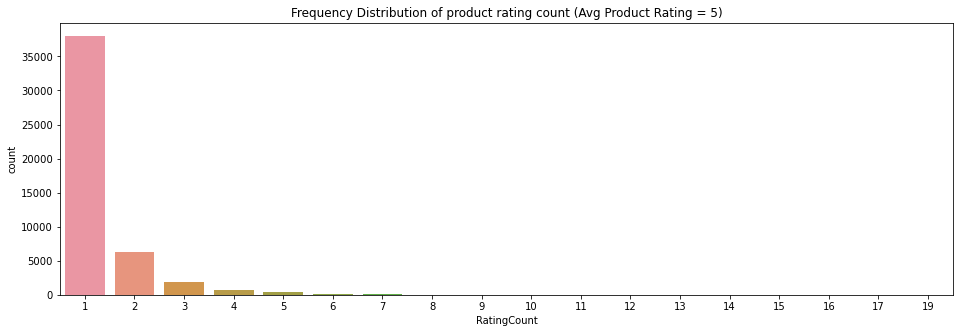

In [9]:
# Look at the distribution of rating counts of products for which average rating is highest (5.0)

plt.figure(figsize=(16,5))
_ = sns.countplot(ratingStatbyProd[ratingStatbyProd['RatingAvg'] == 5]['RatingCount']).set_title('Frequency Distribution of product rating count (Avg Product Rating = 5)')

- All the products with highest average rating (5.0) have less than 20 user ratings
- We may want to remove ratings that are less than 30 (say) to remove products having very few ratings

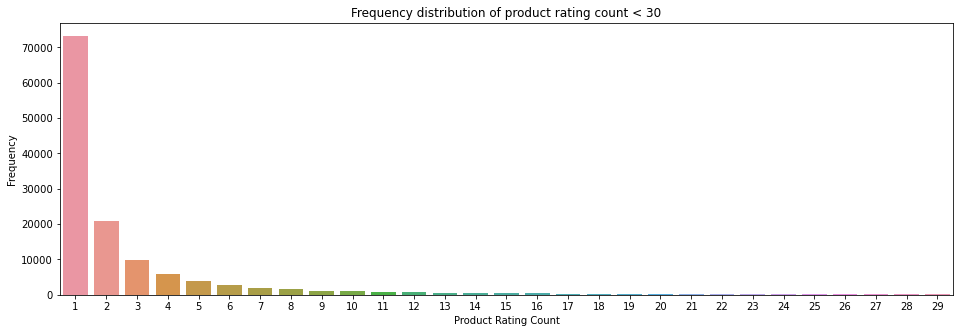

In [10]:
# Look at the frequency distribution of rating counts that are < 30

plt.figure(figsize=(16,5))
_ = sns.countplot(x='RatingCount', data=ratingStatbyProd[ratingStatbyProd['RatingCount'] < 30]).set_title('Frequency distribution of product rating count < 30')
_ = plt.xlabel('Product Rating Count')
_ = plt.ylabel('Frequency')

- There are more than 70000 products with a single rating (i.e., ~56%, out of 130138 total products)

In [11]:
#ratingFilteredP = rating.groupby(['prod_id']).filter(lambda x:x['ratings'].count() >= 30)
iid = ratingStatbyProd[ratingStatbyProd['RatingCount']>=30]['prod_id'].unique()
ratingFilteredP = rating[rating['prod_id'].isin(iid)]

In [12]:
print("Size of dataset got reduced by", '{:.0%}'.format(1-ratingFilteredP.shape[0]/rating.shape[0]), "after filtering for products with more than 30 ratings.")

Size of dataset got reduced by 70% after filtering for products with more than 30 ratings.


### Popularity based Recommender Model

####  We define "popularity" as product with highest average rating meeting the basic criteria of at least 30 user ratings.

First we look at the average rating for each product keeping the number of ratings contributed in mind

In [13]:
ratingFilteredPSumm = ratingFilteredP.groupby(['prod_id']).agg({'user_id':'count','ratings':'mean'})
ratingFilteredPSumm.reset_index(inplace=True)
ratingFilteredPSumm.rename(columns = {'user_id': 'RatingCount','ratings':'RatingAvg'}, inplace=True)

print("\nPopularity based: Top 10 product recommendations as per the highest average user rating\n(among products with at least 30 ratings):")
ratingFilteredPSumm.sort_values(by=['RatingAvg', 'RatingCount'], ascending=False).head(10)


Popularity based: Top 10 product recommendations as per the highest average user rating
(among products with at least 30 ratings):


,prod_id,RatingCount,RatingAvg
408,B001342KM8,30,4.966667
1413,B005LJQM3Y,30,4.933333
1629,B007NZGPAY,39,4.923077
563,B001MSZBNA,37,4.918919
507,B001ENOZY4,36,4.916667
185,B000BNY64C,34,4.911765
63,B000092TT0,55,4.909091
1255,B004Y1AYAC,33,4.909091
564,B001MX5YWI,63,4.904762
355,B000V5P90K,30,4.900000


### Build Collaborative Filtering Model

- User-User collaborative filtering
- Item-Item collaborative filtering (*NB: since we are dealing only with the electronic items, we may try this technique - but in general, we should avoid this unless data is bit granular having very similar-type of items*)

#### User-User Collaborative Filtering

In [14]:
# Look at the distribution of the number of ratings provided by each user

ratingStatbyUser = rating.groupby(['user_id']).agg({'prod_id':'count','ratings':'mean'})
ratingStatbyUser.reset_index(inplace=True)
ratingStatbyUser.rename(columns = {'prod_id': 'RatingCount','ratings':'RatingAvg'}, inplace=True)

print('\nFrequency of number of ratings provided by each user (top and bottom 10):')
ratingFreq = pd.DataFrame(ratingStatbyUser['RatingCount'].value_counts())

df1_styler = ratingFreq.head(10).style.set_table_attributes("style='display:inline'").set_caption('10 Most frequent')
df2_styler = ratingFreq.tail(10).style.set_table_attributes("style='display:inline'").set_caption('10 Least frequent')
display_html(df1_styler._repr_html_()+'\xa0\xa0\xa0\xa0'+df2_styler._repr_html_(), raw=True)


Frequency of number of ratings provided by each user (top and bottom 10):


,RatingCount
1,411121
2,29138
3,5356
4,1522
5,507
6,288
7,152
8,87
9,61
10,28


- The max number of ratings as provided by a user is 36.
- 411121 (92%) out of 448368 users provided only a single rating!! This means the data is very sparse at user level.
- Almost 99% of total users only provided at most three ratings!!
- Warning: User-user collaborative filtering approach may not work well as the algo may not find nearest neighbors for most of the users
- We may want to try with users only providing at least 5 ratings for user-user collaborative filtering. But the sample size will reduce drastically covering only about 1% of users. Thus the model may underfit as it doesn't learn from sufficient number of examples.

#### Partition data into Training and Test sets

In [15]:
# Select only users providing at least 5 ratings
#ratingFilteredU = rating.groupby(['user_id']).filter(lambda x:x['ratings'].count() >= 5)
#uid = ratingStatbyUser[ratingStatbyUser['RatingCount']>=5]['user_id'].unique()
#ratingFilteredU = rating[rating['user_id'].isin(uid)]

In [16]:
# To avoid memory issue and data sparseness, I included users who provided at least 4 ratings

uid = ratingStatbyUser[ratingStatbyUser['RatingCount']>3]['user_id'].unique()
ratingFilteredU = rating[rating['user_id'].isin(uid)]

#print('Proportion of records used (after removing users with single rating):', '{:.1%}'.format(ratingFilteredU.shape[0] / rating.shape[0]))

In [17]:
# transform from pandas format to surprise format
ratingU_surp = Dataset.load_from_df(ratingFilteredU, Reader(rating_scale=(1, 5)))

# partition data into training and test datasets
trainData, testData = train_test_split(ratingU_surp, test_size = 0.3, random_state=1)

In [18]:
print('The no. of users in training set:', trainData.n_users)
print('The no. of products in training set:', trainData.n_items)

The no. of users in training set: 2734
The no. of products in training set: 8094


In [19]:
# User-User Collaborative Filtering
uuCollabFiltering = KNNWithMeans(k=50, sim_options={'name':'pearson_baseline', 'user_based':True})
uuCollabFiltering.fit(trainData)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [20]:
# Run model on test data to predict
testPred = uuCollabFiltering.test(testData)

In [21]:
# Model evaluation
print("User-User Collaborative Model : Test Set score")
_ = accuracy.rmse(testPred, verbose=True)
_ = accuracy.mae(testPred, verbose=True)

User-User Collaborative Model : Test Set score
RMSE: 1.1651
MAE:  0.8686


In [22]:
# Prepare all pairs (u, i) that are NOT in the training set
antiTestData = trainData.build_anti_testset()

In [23]:
# Predict ratings for all pairs (u, i) that are NOT in the training set
predsU = uuCollabFiltering.test(antiTestData)

In [24]:
# Print top 5 recommended items for each user (items that user has never rated) - [user-based recommendation]
top_k = get_top_k(predsU, k=5)
for uid, user_ratings in top_k.items():
    print(uid, [iid for (iid, _) in user_ratings])

A3FOSLM5G1BO63 ['B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2', 'B0007KPRKQ']
A1CR6Y5ELEBVH5 ['B00G6CLN3Y', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2', 'B0007KPRKQ']
A1KC46Z3OSFHD4 ['B00G6CLN3Y', 'B00167340E', 'B002TOJXNU', 'B00G4FCKB2', 'B0007KPRKQ']
A1ODOGXEYECQQ8 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B00G4FCKB2', 'B0007KPRKQ']
AFFVUZEGP1FDQ ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B0007KPRKQ']
A2Q5OYAUY8X412 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1X2LENOF84LCQ ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1BXVZSQOJE6UE ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A6TBR6L2D4XKC ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
AFIR57I2Y901O ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A23FB18MNBX4J5 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3KZ7OH4VRL048 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0',

A64LEAZ2QF8L2 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A13QOK3SKIT9QL ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
AUYT2H281GPNJ ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1MEISNED4NP7U ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2I0Q87CT0D3GK ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A19NP8YYADOOSF ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A32DUKGO59EAHH ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1CM4HI4S5P0WO ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A55CAYQ7Y6CJG ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1IP2K4NHPWZ2I ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2ZR5RLHI1INB1 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1TT5YBX2MXKQX ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0',

A3EK2KTYHJCPB9 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3TQTYD0D6AUO3 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
AXL5GGD8MPGWE ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1F92EK0MUNOVR ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1BITE87QKYF64 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2MYCLMG0D3YR7 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3L6L5O89JTX2T ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A269FH9V0X3593 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
ADOR3TR7GDF68 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1FDV3WPOHREY9 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
ARHILN11ZD4L8 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3077MQTAKOVFZ ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0',

A3BUNHF07TGZS3 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A174BBGE21P9NL ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A17A0Q9LF7K4N2 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
AHGYNZ1588WLB ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A15WLL60JXUU0M ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3I9DMCAY33F3Z ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A24KKRCPD755UI ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3QUG39UDJOPNB ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1I4EPEMTBO8EK ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3LQI6DLFEXOVJ ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2U7C3979YNQV2 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A383XURHVF8ON6 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0

A2K6CDQ9HZ359G ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1AM1WN5M3GD2T ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1B1DJMMVKRQMR ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2AX2UGB167J31 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2HH26HJLVPNVF ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A213POYMNUCVC6 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
AAEVGE52KL0DJ ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1EAH433QK3L3E ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2QT3TUZKVW5ML ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A28ZDVY6NV75P ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1X3ESYZ79H59E ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
AV8MDYLHHTUOY ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0',

A2LQYPB89263DK ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2T9OH7QUYPMXS ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
AFWF1IT147IBE ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2WPL6Y08K6ZQH ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A21D1PLQ36PCTH ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3OYO7B6SS7QLH ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1YW5ZQBEIFN5Q ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2V66GIRLAY1SU ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3KZCNV1N8R9GC ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1YM24Q77XM51N ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A7SHF4WR5HQ77 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A5YTGBQJ6Z2EO ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0',

A34YTZ6R8IIQOM ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1WREVC9FQAFW7 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A21RRRHNH616JK ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A3KF79AODCE7YE ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A305YZ79VZR02F ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A198CCH4NNLI2E ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1VNUU48CSSRSY ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A242IFN64X6R4E ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
ABNYR68EXNSXA ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1CU5CONQX6545 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A1R6RKKE44AYA8 ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0', 'B002TOJXNU', 'B00G4FCKB2']
A2G2QNKDL1Y6AC ['B00G6CLN3Y', 'B00167340E', 'B009AG2YJ0

#### Item-Item Collaborative Filtering

In [25]:
# Item-Item Collaborative Filtering
iiCollabFiltering = KNNWithMeans(k=50, sim_options={'name':'pearson_baseline', 'user_based':False})
iiCollabFiltering.fit(trainData)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [26]:
# Run model on test data to predict
testPred = iiCollabFiltering.test(testData)

In [27]:
# Model evaluation
print("Item-Item Collaborative Model : Test Set score")
_ = accuracy.rmse(testPred, verbose=True)
_ = accuracy.mae(testPred, verbose=True)

Item-Item Collaborative Model : Test Set score
RMSE: 1.1847
MAE:  0.8670


In [28]:
# Predict ratings for all pairs (u, i) that are NOT in the training set
predsI = iiCollabFiltering.test(antiTestData)

In [29]:
# Print top 5 recommended items for each user (items that user has never rated) - [item-based recommendation]
top_k = get_top_k(predsI, k=5)
for uid, user_ratings in top_k.items():
    print(uid, [iid for (iid, _) in user_ratings])

A3FOSLM5G1BO63 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1CR6Y5ELEBVH5 ['B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366', 'B008ULPAT2']
A1KC46Z3OSFHD4 ['B00167340E', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366', 'B008ULPAT2']
A1ODOGXEYECQQ8 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AFFVUZEGP1FDQ ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2Q5OYAUY8X412 ['B00167340E', 'B009AG2YJ0', 'B005CG2AX2', 'B000EW4366', 'B008ULPAT2']
A1X2LENOF84LCQ ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B000EW4366', 'B008ULPAT2']
A1BXVZSQOJE6UE ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A6TBR6L2D4XKC ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AFIR57I2Y901O ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A23FB18MNBX4J5 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B008ULPAT2']
A3KZ7OH4VRL048 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ',

A4U27URFECK1U ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1E31LPLZBVAGI ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A174X7S1J75AZ3 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2NBCCFDISGUQT ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2Y29IRSI08F0I ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A64LEAZ2QF8L2 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A13QOK3SKIT9QL ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AUYT2H281GPNJ ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1MEISNED4NP7U ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2I0Q87CT0D3GK ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A19NP8YYADOOSF ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A32DUKGO59EAHH ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ',

A2XYS6U8Q5B87U ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A3U1FXAQEMIXNM ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1L64KDYO5BOJA ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AO2EURP2Y4JZM ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2MR696ZU17F12 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A3EK2KTYHJCPB9 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A3TQTYD0D6AUO3 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AXL5GGD8MPGWE ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1F92EK0MUNOVR ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1BITE87QKYF64 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2MYCLMG0D3YR7 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A3L6L5O89JTX2T ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ'

AGABK3PVA79PH ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AZ515FFZ7I2P7 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1ZTR0FR5AW9B4 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A23QSTB241NRF3 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2KNLRRVEHFQ2S ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A3T2J7YMQT11Y2 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
ALNE7Q71JFC0F ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1W23COY2XNN4 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2BLFCOPSMBOZ9 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A3K7E39KU4IXBH ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AGATRDOFW48DK ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A33QGRQWND3CD3 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', '

A2PHW6BGDXA7S6 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1BG7TB6HWPLHX ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2KR1481ARVYNP ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AYMYSI7ZL1XGS ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
ANUT78D9JZSB1 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A240DGBCTVRB1W ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2U8CKQJ58PWKG ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A5X444UZBWXW2 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A2VODABWSVHV8E ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
AC1QHKELS0VDC ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A11R5VW7IM6ISQ ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A32EOHLFZYXJEP ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 

A2PB93OF2M6UNM ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A84FLVDK2R5JF ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1NNMOD9H36Q8E ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1R5FUGCG4O1JO ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A34YTZ6R8IIQOM ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1WREVC9FQAFW7 ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A21RRRHNH616JK ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A3KF79AODCE7YE ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A305YZ79VZR02F ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A198CCH4NNLI2E ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A1VNUU48CSSRSY ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ', 'B005CG2AX2', 'B000EW4366']
A242IFN64X6R4E ['B00167340E', 'B009AG2YJ0', 'B0007KPRKQ

### SVD based collaborative filtering

In [30]:
algo = SVD()
algo.fit(trainData)

In [31]:
# Run model on test data to predict
testPred = algo.test(testData)

In [32]:
# Model evaluation
print("SVD Model : Test Set score")
_ = accuracy.rmse(testPred, verbose=True)
_ = accuracy.mae(testPred, verbose=True)

SVD Model : Test Set score
RMSE: 1.1004
MAE:  0.8449


In [33]:
# Predict ratings for all pairs (u, i) that are NOT in the training set
preds = algo.test(antiTestData)

In [34]:
# Print top 5 recommended items for each user (items that user has never rated) - [SVD-based recommendation]
top_k = get_top_k(preds, k=5)
for uid, user_ratings in top_k.items():
    print(uid, [iid for (iid, _) in user_ratings])

A3FOSLM5G1BO63 ['B003ES5ZUU', 'B001TH7GUU', 'B000WS204Y', 'B0019EHU8G', 'B000BVNOZG']
A1CR6Y5ELEBVH5 ['B003ES5ZUU', 'B009SYZ8OC', 'B00ENZRS76', 'B00CYYDDP4', 'B0000514G8']
A1KC46Z3OSFHD4 ['B000B9RI14', 'B000WXA17W', 'B004286VMW', 'B005HSG3JC', 'B003ES5ZUU']
A1ODOGXEYECQQ8 ['B003ES5ZUU', 'B00E3W15P0', 'B0019EHU8G', 'B005DLDO4U', 'B004286VMW']
AFFVUZEGP1FDQ ['B009SYZ8OC', 'B003ES5ZUU', 'B004GF8TIK', 'B0019EHU8G', 'B003ES5ZR8']
A2Q5OYAUY8X412 ['B003ES5ZUU', 'B009SYZ8OC', 'B006W8U2MU', 'B000ENUCR4', 'B001TH7GSW']
A1X2LENOF84LCQ ['B001TH7GUU', 'B003ES5ZUU', 'B009SYZ8OC', 'B003CJTQJW', 'B003U7SR0U']
A1BXVZSQOJE6UE ['B000FBK3QK', 'B003ES5ZUU', 'B002HWRJY4', 'B00GTGETFG', 'B006W8U2MU']
A6TBR6L2D4XKC ['B003ES5ZUU', 'B00DVFLJDS', 'B009NHAEXE', 'B009HU6RI8', 'B008THTWIW']
AFIR57I2Y901O ['B003ES5ZUU', 'B008ULPAT2', 'B004Q3R9AQ', 'B0078KP0SM', 'B005LFT3GG']
A23FB18MNBX4J5 ['B003ES5ZUU', 'B001TH7GUU', 'B009SYZ8OC', 'B0052SCU8U', 'B0036WT4DS']
A3KZ7OH4VRL048 ['B003ES5ZUU', 'B004286VMW', 'B00G0OYHCW',

A3IY316DRNF5F2 ['B003ES5ZUU', 'B00004SSRC', 'B00BERGFV6', 'B004286VMW', 'B00F5NB7MW']
A2QNODR542GZTA ['B000067RT6', 'B00GTGETFG', 'B0054ZLLBS', 'B008AK5C4G', 'B003S68Q0Y']
A8371PWLNWNIR ['B003ES5ZUU', 'B000QUUFRW', 'B009SYZ8OC', 'B003ES5ZR8', 'B001TH7GUU']
A4U27URFECK1U ['B003ES5ZUU', 'B004GUT1QO', 'B009SYZ8OC', 'B00E3W15P0', 'B004GF8TIK']
A1E31LPLZBVAGI ['B003ES5ZUU', 'B00ENZRS76', 'B002V8C3W2', 'B005UNM55U', 'B00CKK8GEU']
A174X7S1J75AZ3 ['B003ES5ZUU', 'B0019EHU8G', 'B004GF8TIK', 'B009HU6RI8', 'B000VY2BC0']
A2NBCCFDISGUQT ['B003ES5ZUU', 'B00822T3I8', 'B004286VMW', 'B00007M1TZ', 'B001XURP7W']
A2Y29IRSI08F0I ['B003ES5ZUU', 'B009SYZ8OC', 'B00DVFLJDS', 'B0062IPIPQ', 'B0082E9K7U']
A64LEAZ2QF8L2 ['B007WTAJTO', 'B0019EHU8G', 'B00829THVO', 'B0013DXVYK', 'B002YIG9AQ']
A13QOK3SKIT9QL ['B009SYZ8OC', 'B003ES5ZUU', 'B00ENZRS76', 'B001T9NUJE', 'B006W8U2MU']
AUYT2H281GPNJ ['B003ES5ZUU', 'B006W8U2MU', 'B00894YP00', 'B000QUUFRW', 'B00CD8ADKO']
A1MEISNED4NP7U ['B001ELJ9QK', 'B004GUT1QO', 'B00129CDGC', 

A8XBR09J4Z421 ['B003ES5ZUU', 'B0019EHU8G', 'B004GF8TIK', 'B005HGBEZ2', 'B0052SCU8U']
A11U7BJTYTZL5V ['B003ES5ZUU', 'B0043WJRRS', 'B000EIDARS', 'B001F7AJKI', 'B007ZG7XVQ']
A2XYS6U8Q5B87U ['B003ES5ZUU', 'B001TH7GUU', 'B000N99BBC', 'B000YHGAMG', 'B00015GYU4']
A3U1FXAQEMIXNM ['B003ES5ZUU', 'B001F7AJKI', 'B0038KN114', 'B005LFT3GG', 'B0043WJRRS']
A1L64KDYO5BOJA ['B000JMJWV2', 'B003VAGXWK', 'B000067RT6', 'B000J01I1G', 'B005HMKKH4']
AO2EURP2Y4JZM ['B003ES5ZUU', 'B004GF8TIK', 'B005HMKKH4', 'B002V8C3W2', 'B001EPVOQY']
A2MR696ZU17F12 ['B003ES5ZUU', 'B001TH7GUU', 'B005HMKKH4', 'B000EDNOEC', 'B00GTGETFG']
A3EK2KTYHJCPB9 ['B003ES5ZUU', 'B00DVFLJDS', 'B000JO3N3S', 'B0062IPIPQ', 'B002V8C3W2']
A3TQTYD0D6AUO3 ['B004286VMW', 'B00EKAPZ8S', 'B003ES5ZUU', 'B004GUT1QO', 'B0043WJRRS']
AXL5GGD8MPGWE ['B009SYZ8OC', 'B004286VMW', 'B00834SJSK', 'B0019EHU8G', 'B002WR7VSS']
A1F92EK0MUNOVR ['B003ES5ZUU', 'B000EVSLRO', 'B001TH7GUU', 'B000N99BBC', 'B000067RT6']
A1BITE87QKYF64 ['B001TH7GUU', 'B003ES5ZUU', 'B00L2442H0',

ANXXKNIGXTAS0 ['B003ES5ZUU', 'B001TH7GUU', 'B0019EHU8G', 'B00004WCIC', 'B004GF8TIK']
AM7UOQOBLEOXB ['B004286VMW', 'B00D1KWRMA', 'B009SYZ8OC', 'B001D60LG8', 'B004XC6GJ0']
A148F4ZOSD82OW ['B009SYZ8OC', 'B001TH7GUU', 'B002VKVZ1A', 'B007WTAJTO', 'B003DZ166Q']
A2XXBZPQT5EXHV ['B003ES5ZUU', 'B009SYZ8OC', 'B005YW7OLM', 'B00829THVO', 'B002V8C3W2']
A3M82NO6OU1FHS ['B003ES5ZUU', 'B004GF8TIK', 'B000J01I1G', 'B0017H4G0A', 'B00ENZRS76']
A1RGK6Q5WUZUBA ['B009SYZ8OC', 'B004GUT1QO', 'B007WTAJTO', 'B004286VMW', 'B00ENZRS76']
AVVHQR48M82J4 ['B003ES5ZUU', 'B00829THVO', 'B0071CVTAK', 'B00358RJG2', 'B006MRAVFE']
AM1D8O2CRCAE0 ['B003ES5ZUU', 'B009SYZ8OC', 'B000JMJWV2', 'B00834SJSK', 'B004GF8TIK']
AGABK3PVA79PH ['B003CJTQJC', 'B002IO2UM2', 'B004286VMW', 'B003ES5ZUU', 'B0002MQGOK']
AZ515FFZ7I2P7 ['B009SYZ8OC', 'B003ES5ZUU', 'B0019EHU8G', 'B00BZC31WQ', 'B001TH7GUU']
A1ZTR0FR5AW9B4 ['B003ES5ZUU', 'B00BT7RAPG', 'B0019EHU8G', 'B005AAVNQU', 'B002V8C3W2']
A23QSTB241NRF3 ['B00829THVO', 'B005HMKKH4', 'B003ES5ZUU', 'B

A1B6O7SAIYG2N0 ['B003ES5ZUU', 'B0019EHU8G', 'B00DVFLJDS', 'B00E3W15P0', 'B009SYZ8OC']
A37EIQ3PF2UDGX ['B003ES5ZUU', 'B009SYZ8OC', 'B00BT7RAPG', 'B007WTAJTO', 'B000O6KEMO']
A1Q5P5ML3176C0 ['B003ES5ZUU', 'B004286VMW', 'B000HPV3RW', 'B00004ZCJE', 'B00FLNYH8M']
A2D3KZEQTM89WO ['B003ES5ZUU', 'B007ABANFY', 'B002RM08RE', 'B002QAUN2M', 'B00L2442H0']
AP37ZBVD77DUE ['B003ES5ZUU', 'B00829THVO', 'B00F5NB7MW', 'B005HMKKH4', 'B00CSMYBFS']
A3VQFUAB6WQXMU ['B003ES5ZUU', 'B0019EHU8G', 'B009SYZ8OC', 'B006ZBWV0K', 'B00829THVO']
A2C9ZOF0R2JQTO ['B003ES5ZUU', 'B005HMKKH4', 'B000V5P90K', 'B00E3W15P0', 'B003CJTQJW']
A2HHAV29CZ1OIE ['B003ES5ZUU', 'B00DVFLJDS', 'B004GF8TIK', 'B006W8U2MU', 'B001NLJU0G']
A3QQCEQ33O0GJU ['B003ES5ZUU', 'B00005LE77', 'B005HMKKH4', 'B009SYZ8OC', 'B007WTAJTO']
A3N0P5AAMP6XD2 ['B001EPVOQY', 'B003ES5ZUU', 'B00E3W15P0', 'B009SYZ8OC', 'B004ETQHV4']
AU2UJF4I7KAWL ['B003ES5ZUU', 'B002V8C3W2', 'B00829THVO', 'B0096KY9YS', 'B000L475L2']
A2E4Z216B8LFLZ ['B000J01I1G', 'B009SYZ8OC', 'B001U3F1YG'

A2QIC4G483SQQA ['B009SYZ8OC', 'B003ES5ZUU', 'B006W8U2MU', 'B007WTAJTO', 'B000VX6XL6']
A3L82NI82NUDYM ['B003ES5ZUU', 'B002IO2UM2', 'B001212ELY', 'B000KX8TCI', 'B000QUUFRW']
A2SUSMSKDK6JL0 ['B000QUUFRW', 'B002V8C3W2', 'B00ENZRS76', 'B004286VMW', 'B003ES5ZUU']
A3BI8BKIHESDNQ ['B004286VMW', 'B003ES5ZUU', 'B0019EHU8G', 'B008ULPAT2', 'B007WTAJTO']
A2RH40BEAX3V8P ['B003ES5ZUU', 'B000VY2BC0', 'B005DMBUZY', 'B001F7AJKI', 'B006WIG8Z0']
A3859W0UMFT6OG ['B007BXD66E', 'B002V8C3W2', 'B006W8U2MU', 'B007WTAJTO', 'B00BQ5RY1G']
A145K6RGUUMAEO ['B003ES5ZUU', 'B003ES5ZR8', 'B0062IPIPQ', 'B005YW7OLM', 'B001TH7GUU']
A4IL0CLL27Q33 ['B003ES5ZUU', 'B001XURP7W', 'B008RM235I', 'B005HMKKH4', 'B007G5NNOW']
AIO00LM9IL7FA ['B000BQ7GW8', 'B004286VMW', 'B001IBHUU8', 'B009SYZ8OC', 'B0019EHU8G']
A11SPSEM08VIXX ['B003ES5ZUU', 'B009SYZ8OC', 'B001XURP7W', 'B006W8U2MU', 'B00CO8TBQ0']
A23PCEL26412R1 ['B009SYZ8OC', 'B003ES5ZUU', 'B0000696HN', 'B004GF8TIK', 'B004WB8EYM']
A1PVJICI412IN4 ['B003ES5ZUU', 'B0043WJRRS', 'B00BB6LTI4'

### Summary:
- Given dataset on eletronic ratings is very sparse with almost 92% of all users provided only a single rating while about 99% of all users provided at most three ratings. That is, the data is largely affected by cold start problem.
- To handle cold start problems, we can use popularity based recommendation model that considers trends and ignores other factors like the number of ratings to recommend items to users
- We used popularity based model ignoring products that had less than 30 user-ratings
- We also looked at the collaborative filtering methods (memory-based -> user-user and item-item, model based -> SVD) for new product recommendation to users
- For collaborative filtering analysis, we considered records for those users that rated at least 4 products. This is to avoid memory error and handle sparseness in the data.
- User-based collaborative filtering is based on similar tastes between two users; while item-based collaborative filtering is based on similarities of ratings between two items. Ideally item-based recommendation requires granular level of data where items are from very similar categories. In this case, we can go for item-based collaborative system as items are electronics.
- SVD model based recommender learns the user's preferences based on the previous interactions of the user
- In terms of comparison of accuracy for various collaborative systems, user-based recommender model (RMSE 1.18, MAE: 0.87) provides similar performance with item-based model (RMSE 1.16, MAE: 0.87), while SVD-based model (RMSE: 1.10, MAE: 0.85) provides the best performing recommender model. We could also use k-fold cross-validation on full dataset and use that to prepare recommender. However, due to computation time and memory efficiency, this couldn't be performed.
- Due to the presence of cold start problem, it is hard to get better recommendation models using collaborative filtering as nearest neighbors are hard to find.

## <center><font color='green'>*******End of Project Solution*******</font></center>